## Applying Machine Learning to Trading Strategies: Using Logistic Regression to Build Momentum-based Trading Strategies - <br>`Patrick Beaudan and Shuoyuan He`

Objectives :

    1. Use of ML Model, Logistic Regression, to build a time-series dual momentum trading strategy on the S&P 500 Index
    2. Showing how the proposed model outperforms both buy-and-hold and several base-case dual momentum strategies, significantly increasing returns and reducing risk
    3. Applying the algorithm to other U.S. and international large capitalization equity indices 
    4. Analyzing yields improvements in risk-adjusted performance. 

### 1. Fetching data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
import yfinance as yf 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

plt.style.use('seaborn-v0_8-darkgrid')
import warnings
warnings.filterwarnings('ignore') 

#### Tickers 
1. S&P 500 Index: `^GSPC`
2. S&P Small Cap 600 Index (SML): ^SML   
3. S&P Mid Cap 400 Index (MID): `^MID`
4. FTSE 100 Index (UKX): `^FTSE`
5. FTSEurofirst 300 Index (E300): ^FTEU3  
6. Tokyo Stock Exchange Price Index (TPX): ^TPX  
7. Dow Jones Industrial Average Index (INDU): `^DJI`
8. Dow Jones Transportation Average Index (TRAN): `^DJT`

In [2]:
end = '2023-12-31'

# df_sml = yf.download('^SML',start='1993-12-31',end=end) ==> Data not available
# df_mid = yf.download('^MID',start='1990-12-31',end=end) 
# df_mid.to_csv('SPMidCap400---.csv')
# df_ukx = yf.download('^FTSE',start='1997-12-19',end=end)
# df_ukx.to_csv('FTSE100---.csv') 
# df_e300 = yf.download('^FTEU3',start='1985-12-31',end=end) ==> Data not available
# df_tpx = yf.download('^TPX',start='1997-12-19',end=end) ==> Data not available
# df_dji = yf.download('^DJI',start='1920-01-02',end=end)
# df_dji.to_csv('DJIndustry---.csv')
# df_djt = yf.download('^DJT',start='1920-01-02',end=end) 
# df_djt.to_csv('DJTransport---.csv')
# df_sp500 = yf.download('^GSPC',start='1927-12-30',end=end)
# df_sp500.to_csv('SP500---.csv')  

In [3]:
df_mid = pd.read_csv('SPMidCap400---.csv')
df_mid.set_index('Date', inplace=True)

df_ukx = pd.read_csv('FTSE100---.csv')
df_ukx.set_index('Date', inplace=True) 

df_dji = pd.read_csv('DJIndustry---.csv')
df_dji.set_index('Date', inplace=True)

df_djt = pd.read_csv('DJTransport---.csv') 
df_djt.set_index('Date', inplace=True) 

data = pd.read_csv('SP500---.csv')
data.set_index('Date',inplace=True) 

df_21 = data.copy() 

print('Shape of data : ',data.shape) 
data.tail(3) 

Shape of data :  (24115, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,4781.580078,2748450000
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,4783.350098,2698860000
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,4769.830078,3126060000


### 2. Defining class to include base-features Momentum and Drawdown

* Momentum features are calculated over time frames of 30, 60, 90, 120, 180, 270, 300, 360 days
* Drawdown features are calculated over time frames of 15, 60, 90, 120 days

Also, it is instructed to calculate features by skipping last month. We follow the convention of 252 business days per calendar year and 21 business days per calendar month.

Features are selected based on the fact that observing the change in the shape of the price history using multiple historical time windows for momenta and drawdowns is more pertinent than considering other metrics to predict short-term profitability. So, we use momenta and drawdowns of different timeframes as features

In [4]:
class IncludeFeatures:
    def __init__(self,data):
        self.data = data 

    def calculate_momentum(self,window): # computing the rate of change in the stock's closing price over window days
        self.data[f'momntm_{window}'] =  self.data['Adj Close'] - self.data['Adj Close'].shift(window) 

    def calculate_drawdown(self,window): # Compute the drawdown by finding the peak and trough in the price data
        # calculating cumulative maximum for stocks price
        self.data['Cumulative_Peak'] = self.data['Adj Close'].cummax() # max of cumulative value upto that day
        # calculating drawdown 
        self.data[f'drwdwn_{window}'] = (self.data['Adj Close']-self.data['Cumulative_Peak'])/self.data['Cumulative_Peak']

    def include_features(self):
        
        momentum_windows = [30, 60, 90, 120, 180, 270, 300, 360]
        drawdwn_windows = [15, 60, 90, 120]    

        for days in momentum_windows:
            self.calculate_momentum(days) 

        for days in drawdwn_windows:
            self.calculate_drawdown(days) 
        
        self.data.drop(columns=['Cumulative_Peak','Open','High','Low','Close','Volume'],axis=1,inplace=True)
        return self.data     

In [5]:
include_feat = IncludeFeatures(data) 
data_feat = include_feat.include_features()
data_feat.dropna(inplace=True)
print(data_feat.shape) 
data_feat.head(3) 

(23755, 13)


,Adj Close,momntm_30,momntm_60,momntm_90,momntm_120,momntm_180,momntm_270,momntm_300,momntm_360,drwdwn_15,drwdwn_60,drwdwn_90,drwdwn_120
Date,,,,,,,,,,,,,
1929-06-10,25.270000,-0.309999,-0.459999,-0.090000,2.74,4.090000,5.060001,6.380001,7.610001,-0.041714,-0.041714,-0.041714,-0.041714
1929-06-11,25.430000,-0.100000,-0.650000,-0.020000,2.99,4.250000,5.070000,6.480000,7.670000,-0.035647,-0.035647,-0.035647,-0.035647
1929-06-12,25.450001,-0.490000,-0.590000,-0.289999,2.75,4.230001,5.010000,6.170000,7.730001,-0.034888,-0.034888,-0.034888,-0.034888


In [6]:
print(f'Null values : {data_feat.isna().sum().sum()}') 

Null values : 0


### 3. Analyzing Key Performance Indicators over sample indices over the entire period

KPIs analysed here are Annual Return, Sharpe Ratio, Volatility, Maximum Drawdown, Average Daily Drawdown

In [7]:
class KPIs:
    def __init__(self,data):
        self.datac = data  

    def annual_return(self,datac):
        cumulative_returns = (1+datac['Daily_Return']).prod()-1 
        n_days = datac.shape[0]     # Number of trading days 
        annualized_return = (1+cumulative_returns)**(252/n_days)-1
        return annualized_return 
    
    def sharpe_ratio(self,datac):
        average_return = datac['Daily_Return'].mean() 
        risk_free_rate = 0.01/252  # constant 1% annual risk-free rate
        std_dev = datac['Daily_Return'].std() 
        sharpe_ratio = (average_return-risk_free_rate)*10/std_dev
        return sharpe_ratio 

    def volatility(self,datac):
        daily_volatility = datac['Daily_Return'].std()
        trading_days_per_year = 252 
        annual_volatility = daily_volatility*np.sqrt(trading_days_per_year)   # Annualizing Volatility
        return annual_volatility 
    
    def max_drawdown(self,datac):
        datac['Running_max'] = datac['Adj Close'].cummax() 
        datac['Drawdowns'] = (datac['Adj Close']-datac['Running_max'])/datac['Running_max']

        max_drawdown = datac['Drawdowns'].min() 
        avg_drawdown = datac['Drawdowns'].mean() 

        return max_drawdown, avg_drawdown 

    def calculate_kpi(self):        
        self.datac['Log_Return'] =  np.log(self.datac['Adj Close']/self.datac['Adj Close'].shift(1))
        self.datac['Daily_Return'] = self.datac['Adj Close'].pct_change() 
        self.datac.dropna(inplace=True) 

        annualized_return = self.annual_return(self.datac)
        sharpe_ratio = self.sharpe_ratio(self.datac)
        annual_volatility = self.volatility(self.datac)
        max_drawdown, avg_drawdown = self.max_drawdown(self.datac)

        print(f'Annual Return : {annualized_return*100:.1f}%')
        print(f'Sharpe Ratio : {sharpe_ratio:.2f}')
        print(f'Volatility : {annual_volatility*100:.0f}%')
        print(f'Maximum Drawdown : {max_drawdown*100:.0f}%')
        print(f'Average Daily Drawdown : {avg_drawdown*100:.0f}%') 

        self.datac.drop(columns=['Log_Return','Daily_Return','Running_max','Drawdowns'],axis=1,inplace=True)  

In [8]:
calc_indices = {'S&P 500':data, 'S&P Mid Cap':df_mid, 'FTSE 100':df_ukx, 'DJ Industry':df_dji, 
                'DJ Transport':df_djt}

for ind,df in calc_indices.items():
    print() 
    print('='*20,f'Performace Metrics of {ind}','='*20)
    print() 
    calc_kpi = KPIs(df)
    calc_kpi.calculate_kpi()        


==================== Performace Metrics of S&P 500 ====================

Annual Return : 5.7%
Sharpe Ratio : 0.21
Volatility : 19%
Maximum Drawdown : -86%
Average Daily Drawdown : -21%

==================== Performace Metrics of S&P Mid Cap ====================

Annual Return : 10.6%
Sharpe Ratio : 0.35
Volatility : 20%
Maximum Drawdown : -56%
Average Daily Drawdown : -7%

==================== Performace Metrics of FTSE 100 ====================

Annual Return : 1.7%
Sharpe Ratio : 0.08
Volatility : 19%
Maximum Drawdown : -53%
Average Daily Drawdown : -15%

==================== Performace Metrics of DJ Industry ====================

Annual Return : 8.0%
Sharpe Ratio : 0.30
Volatility : 18%
Maximum Drawdown : -54%
Average Daily Drawdown : -8%

==================== Performace Metrics of DJ Transport ====================

Annual Return : 8.0%
Sharpe Ratio : 0.26
Volatility : 23%
Maximum Drawdown : -61%
Average Daily Drawdown : -13%


# I. Buy and Hold Strategy

In [9]:
databnh = data.copy()
databnh['Momentum'] = (databnh['Adj Close'].pct_change(periods=252)*100).round(2)  # 252 days 
databnh.dropna(inplace=True)
databnh.head()  

,Adj Close,momntm_30,momntm_60,momntm_90,momntm_120,momntm_180,momntm_270,momntm_300,momntm_360,drwdwn_15,drwdwn_60,drwdwn_90,drwdwn_120,Momentum
Date,,,,,,,,,,,,,,
1930-06-13,22.260000,-2.039999,-1.770000,-0.750000,2.100000,-9.119999,-3.580000,-2.600000,-2.590000,-0.301318,-0.301318,-0.301318,-0.301318,-12.47
1930-06-16,20.559999,-3.010000,-3.580000,-2.750000,0.299999,-10.240000,-5.410000,-4.740000,-3.690001,-0.354677,-0.354677,-0.354677,-0.354677,-19.21
1930-06-17,20.580000,-2.400000,-3.710001,-2.480000,0.190001,-10.270000,-5.510000,-4.469999,-3.590000,-0.354049,-0.354049,-0.354049,-0.354049,-20.36
1930-06-18,19.860001,-3.900000,-4.420000,-3.109999,-0.980000,-11.269999,-5.529999,-4.969999,-4.680000,-0.376648,-0.376648,-0.376648,-0.376648,-23.41
1930-06-19,20.790001,-2.519999,-3.459999,-2.330000,-0.029999,-9.480000,-4.910000,-3.839998,-3.789999,-0.347458,-0.347458,-0.347458,-0.347458,-21.28


In [10]:
databnh = databnh[['Adj Close','Momentum']]
databnh['Signal_LO'] = 0

for i in range(len(databnh)):
    if databnh['Momentum'].iloc[i] >= 5:
        databnh.loc[databnh.index[i], 'Signal_LO'] = 1
    else:
        databnh.loc[databnh.index[i], 'Signal_LO'] = 0  

* Signal 1 - There is a high probabolity that the price will go up tomorrow, so, if you have the asset with you, hold it otherwise buy
* Signal - 0 - Do nothing 
* Signal -1 - There is a chance for price to go down, so, sell your asset

In [11]:
databnh['Signal_LO'].value_counts() 

Signal_LO
1    13984
0     9518
Name: count, dtype: int64

In [12]:
databnh['Daily_Returns'] = databnh['Adj Close'].pct_change()  
databnh.dropna(inplace=True)  
databnh['Benchmark'] = (1 + databnh['Daily_Returns']).cumprod() - 1

databnh['Strategy_Returns_LO'] = databnh['Daily_Returns'] * databnh['Signal_LO']   
databnh['Strategy_Returns_LO'].fillna(0, inplace=True)
databnh['Cumulative_Returns_LO'] = (1 + databnh['Strategy_Returns_LO']).cumprod() - 1 

In [13]:
databnh.head() 

,Adj Close,Momentum,Signal_LO,Daily_Returns,Benchmark,Strategy_Returns_LO,Cumulative_Returns_LO
Date,,,,,,,
1930-06-16,20.559999,-19.21,0,-0.076370,-0.076370,-0.0,0.0
1930-06-17,20.580000,-20.36,0,0.000973,-0.075472,0.0,0.0
1930-06-18,19.860001,-23.41,0,-0.034985,-0.107817,-0.0,0.0
1930-06-19,20.790001,-21.28,0,0.046828,-0.066038,0.0,0.0
1930-06-20,20.250000,-23.35,0,-0.025974,-0.090297,-0.0,0.0


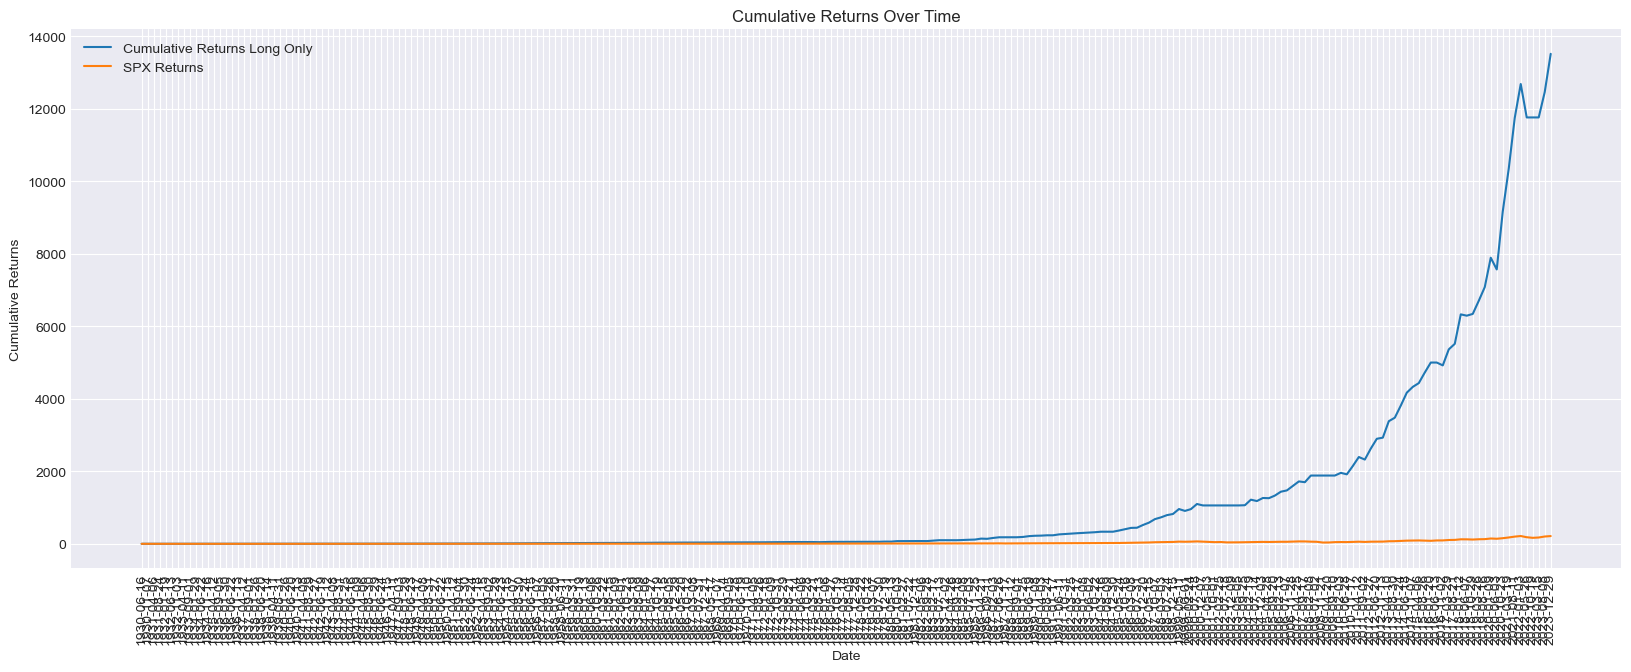

In [14]:
# Plotting the Cumulative Returns

databnh_sampled = databnh.iloc[::100]

plt.figure(figsize=(20, 7))
plt.plot(databnh_sampled.index, databnh_sampled['Cumulative_Returns_LO'], label='Cumulative Returns Long Only')
# plt.plot(databnh_sampled.index, databnh_sampled['Cumulative_Returns_LS'], label='Cumulative Returns Long Short')
plt.plot(databnh_sampled.index, databnh_sampled['Benchmark'], label='SPX Returns') 
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show() 

In [15]:
print('='*20,'Comparing Retunrs','='*20) 
print()
print('Returns from SPX : $',(databnh['Benchmark'].iloc[-1]).round(2))
print('Returns from Buy and Hold Strategy : $',(databnh['Cumulative_Returns_LO'].iloc[-1]).round(2)) 

==================== Comparing Retunrs ====================

Returns from SPX : $ 213.28
Returns from Buy and Hold Strategy : $ 13518.86


# II. Classical Time Series Dual-Momentum Trading Strategy

#### Strategy

1. The momentum, i.e. the percentage price change of a security, is calculated over a historical time horizon of twelve months, skipping the most recent month 
2. If momentum > threshold (here,5%=0.05) => Invest 
3. If momentum < threshold => the portfolio is moved to cash in the long-only strategy, or moved to a short position in the long-short strategy 
4. This investment decision is revisited at regular intervals of one month 

Calculating momentum, percentage change

In [16]:
trading_days_per_month = 21
no_of_months = 12  
time_horizon = trading_days_per_month*no_of_months # 252 days 

df_21['Momentum'] = df_21['Adj Close'].pct_change(periods=252)*100
df_21.dropna(inplace=True)
df_21.drop(columns=['Open','High','Low','Close','Volume', 'Adj Close'],axis=1,inplace=True)

df_21.head(3) 

,Momentum
Date,
1929-01-03,40.770107
1929-01-04,39.921172
1929-01-07,36.851021


### Signals are generated every 21 days

In [17]:
def generate_signals(df_g, interval, threshold = 5):    # intern=val in days
    df_g['Signal_LO'] = 0
    df_g['Signal_LS'] = 0

    for i in range(interval, len(df_g), interval):
        if df_g['Momentum'].iloc[i] >= threshold:
            df_g['Signal_LO'].iloc[i] = 1  # Invest
            df_g['Signal_LS'].iloc[i] = 1  # Invest
        else:
            df_g['Signal_LO'].iloc[i] = 0  # Invest
            df_g['Signal_LS'].iloc[i] = -1 # Move to cash or short position

    return df_g 

# df21_sampled = df_21.iloc[::21] 

In [18]:
df_10 = generate_signals(df_21, 1, 5) 
df_10.head() 

,Momentum,Signal_LO,Signal_LS
Date,,,
1929-01-03,40.770107,0,0
1929-01-04,39.921172,1,1
1929-01-07,36.851021,1,1
1929-01-08,37.720804,1,1
1929-01-09,38.958104,1,1


In [19]:
df_10['Signal_LO'].value_counts()

Signal_LO
1    14190
0     9673
Name: count, dtype: int64

In [20]:
df_10['Signal_LS'].value_counts()

Signal_LS
 1    14190
-1     9672
 0        1
Name: count, dtype: int64

In [21]:
# df_LO = df_10[df_10['Signal_LO']!=0] 

In [22]:
df_LS = pd.DataFrame() 
df_LS = df_10.drop(columns=['Signal_LO'])
df_LS = df_LS.rename(columns={'Signal_LS':'Signal'}) 
df_LS = df_LS.iloc[1:]
df_LS.head() 

,Momentum,Signal
Date,,
1929-01-04,39.921172,1
1929-01-07,36.851021,1
1929-01-08,37.720804,1
1929-01-09,38.958104,1
1929-01-10,40.457142,1


In [23]:
df_LS['Signal'].value_counts()

Signal
 1    14190
-1     9672
Name: count, dtype: int64

In [24]:
df_LO = df_10.drop(columns=['Signal_LS'])
df_LO = df_LO.rename(columns={'Signal_LO':'Signal'}) 
df_LO.head() 

,Momentum,Signal
Date,,
1929-01-03,40.770107,0
1929-01-04,39.921172,1
1929-01-07,36.851021,1
1929-01-08,37.720804,1
1929-01-09,38.958104,1


In [25]:
df_LO['Signal'].value_counts() 

Signal
1    14190
0     9673
Name: count, dtype: int64

## Machine Learning Approach

### 4. Defining Function to create polynomial features

In [26]:
def degree(data,degree): 

    feature_names = data.columns 
    # feature_names = ['Adj Close', 'momntm_30', 'momntm_60', 'momntm_90', 'momntm_120',
    #                  'momntm_180', 'momntm_270', 'momntm_300', 'momntm_360', 'drwdwn_15',
    #                  'drwdwn_60', 'drwdwn_90', 'drwdwn_120'] 
    
    if data.shape[1] != len(feature_names):
        raise ValueError("The number of features in the data does not match the length of feature names.")

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_feat = poly.fit_transform(data) 
    
    feature_names_poly = poly.get_feature_names_out(input_features=feature_names)
    
    df_poly = pd.DataFrame(poly_feat, columns=feature_names_poly, index=data.index) 
    print(f'Shape of df_poly of degree 1 : ',data.shape) 
    print(f'Shape of df_poly of degree {degree} : ',df_poly.shape) 
    print('Number of duplicate columns : ',len(df_poly.columns)-len(set(df_poly.columns))) 
    return df_poly 

In [27]:
x_quad = degree(data_feat,2)  

Shape of df_poly of degree 1 :  (23754, 13)
Shape of df_poly of degree 2 :  (23754, 104)
Number of duplicate columns :  0


In [28]:
x_cubic = degree(data_feat,3) 

Shape of df_poly of degree 1 :  (23754, 13)
Shape of df_poly of degree 3 :  (23754, 559)
Number of duplicate columns :  0


### 5. Creating Datasets for training with Target Variable

In [29]:
def dataset_target_degree(data_feat, x_quad, x_cubic, df_LO, df_LS):

    x_linear_lo = df_LO.join(data_feat) 
    x_linear_lo.dropna(inplace=True)   

    x_linear_ls = df_LS.join(data_feat) 
    x_linear_ls.dropna(inplace=True)  
    
    x_quad_lo = df_LO.join(x_quad) 
    x_quad_lo.dropna(inplace=True)  

    x_quad_ls = df_LS.join(x_quad) 
    x_quad_ls.dropna(inplace=True) 

    x_cubic_lo = df_LO.join(x_cubic) 
    x_cubic_lo.dropna(inplace=True)  

    x_cubic_ls = df_LS.join(x_cubic) 
    x_cubic_ls.dropna(inplace=True)  
    
    return x_linear_lo, x_linear_ls, x_quad_lo, x_quad_ls, x_cubic_lo, x_cubic_ls 

In [30]:
x_linear_lo, x_linear_ls, x_quad_lo, x_quad_ls, x_cubic_lo, x_cubic_ls  = dataset_target_degree(data_feat, x_quad, x_cubic, df_LO, df_LS)

#### 5.1 Linear dataset

In [31]:
print('Shape of linear dataset before concatenation for Long Only: ',data_feat.shape)
print('Shape of linear dataset after concatenation for Long Only: ',x_linear_lo.shape) 

Shape of linear dataset before concatenation for Long Only:  (23754, 13)
Shape of linear dataset after concatenation for Long Only:  (23754, 15)


In [32]:
print('Shape of linear dataset before concatenation for Long Short: ',data_feat.shape)
print('Shape of linear dataset after concatenation Long Short: ',x_linear_ls.shape) 

Shape of linear dataset before concatenation for Long Short:  (23754, 13)
Shape of linear dataset after concatenation Long Short:  (23754, 15)


#### 5.2 Quadratic dataset

In [33]:
print('Shape of quadratic dataset before concatenation for Long Only: ',x_quad.shape)
print('Shape of quadratic dataset after concatenation for Long Only: ',x_quad_lo.shape) 

Shape of quadratic dataset before concatenation for Long Only:  (23754, 104)
Shape of quadratic dataset after concatenation for Long Only:  (23754, 106)


In [34]:
print('Shape of quadratic dataset before concatenation Long Short: ',x_quad.shape)
print('Shape of quadratic dataset after concatenation Long Short: ',x_quad_ls.shape) 

Shape of quadratic dataset before concatenation Long Short:  (23754, 104)
Shape of quadratic dataset after concatenation Long Short:  (23754, 106)


#### 5.3 Cubic dataset

In [35]:
print('Shape of cubic dataset before concatenation for Long Only: ',x_cubic.shape)
print('Shape of cubic dataset after concatenation for Long Only: ',x_cubic_lo.shape) 

Shape of cubic dataset before concatenation for Long Only:  (23754, 559)
Shape of cubic dataset after concatenation for Long Only:  (23754, 561)


In [36]:
print('Shape of cubic dataset before concatenation Long Short: ',x_cubic.shape) 
print('Shape of cubic dataset after concatenation Long Short: ',x_cubic_ls.shape) 

Shape of cubic dataset before concatenation Long Short:  (23754, 559)
Shape of cubic dataset after concatenation Long Short:  (23754, 561)


### 7. Class for Training and Evaluating the Model

Model metrics calculated are cost function, accuracy, confusion matrix and classification report. 

To calculate the cost function, also known as the loss function, for logistic regression, we need to use the logistic loss function, which is commonly referred to as cross-entropy loss or log loss.

In [37]:
class logistic_regression:
    def __init__(self):
        self.train_size = 0.4
        self.random_state = 42 

    def scaling_x(self,X):
        scaler = StandardScaler()
        scaled_X = scaler.fit_transform(X)
        return scaled_X
    
    def cost_func(self,model,x_test,y_test): 
        probabilities = model.predict_proba(x_test)[:,1] # Getting probabilities for class 1 (positive class)
        cost = log_loss(y_test,probabilities) 
        return cost 

    def model_metrics(self,model,x_test,y_test):
        y_pred = model.predict(x_test) 
        cost_fn = self.cost_func(model,x_test,y_test)
        accuracy = accuracy_score(y_test,y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)

        print(f'Cost function : {cost_fn:.2f}') 
        print(f'Accuracy : {accuracy:.2f}')
        print('Confusion Matrix : ')
        print(conf_matrix) 
        print('Classification Report : ')
        print(class_report) 
    
    def training_model(self,df):

        X = df.drop(columns=['Signal'],axis=1)
        Y = df['Signal']  

        scaled_X = self.scaling_x(X)
        # Split the data into initial training set (40%) and test set (60%)
        x_train, x_test, y_train, y_test = train_test_split(scaled_X,Y,train_size=0.4, shuffle=False, 
                                                            random_state=42)
        model = LogisticRegression(C=1.0)   # C is the regularization parameter
        
        model.fit(x_train,y_train) 

        print('='*20,'Metrics for Train set','='*20)
        print()    
        self.model_metrics(model,x_train,y_train) 
        print('='*20,'Metrics for Test set','='*20)
        print()    
        self.model_metrics(model,x_test,y_test) 
        print()  
        
logistic = logistic_regression()    

### 8. Evaluation of Linear, Quadratic and Cubic Combination of features

#### 8.1 Evaluation on Linear Combination of features

In [38]:
logistic.training_model(x_linear_lo)  

==================== Metrics for Train set ====================

Cost function : 0.03
Accuracy : 1.00
Confusion Matrix : 
[[4574    1]
 [  19 4907]]
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4575
           1       1.00      1.00      1.00      4926

    accuracy                           1.00      9501
   macro avg       1.00      1.00      1.00      9501
weighted avg       1.00      1.00      1.00      9501

==================== Metrics for Test set ====================

Cost function : 0.06
Accuracy : 0.98
Confusion Matrix : 
[[5096    1]
 [ 258 8898]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      5097
           1       1.00      0.97      0.99      9156

    accuracy                           0.98     14253
   macro avg       0.98      0.99      0.98     14253
weighted avg       0.98      0.98      0.98     14253


In [39]:
logistic.training_model(x_linear_ls)   

==================== Metrics for Train set ====================

Cost function : 0.03
Accuracy : 1.00
Confusion Matrix : 
[[4574    1]
 [  19 4907]]
Classification Report : 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4575
           1       1.00      1.00      1.00      4926

    accuracy                           1.00      9501
   macro avg       1.00      1.00      1.00      9501
weighted avg       1.00      1.00      1.00      9501

==================== Metrics for Test set ====================

Cost function : 0.06
Accuracy : 0.98
Confusion Matrix : 
[[5096    1]
 [ 258 8898]]
Classification Report : 
              precision    recall  f1-score   support

          -1       0.95      1.00      0.98      5097
           1       1.00      0.97      0.99      9156

    accuracy                           0.98     14253
   macro avg       0.98      0.99      0.98     14253
weighted avg       0.98      0.98      0.98     14253


#### 8.2 Evaluation on Quadratic Combination of features

In [39]:
logistic.training_model(x_quad_lo) 

==================== Metrics for Train set ====================

Cost function : 0.03
Accuracy : 1.00
Confusion Matrix : 
[[4566    9]
 [  20 4906]]
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4575
           1       1.00      1.00      1.00      4926

    accuracy                           1.00      9501
   macro avg       1.00      1.00      1.00      9501
weighted avg       1.00      1.00      1.00      9501

==================== Metrics for Test set ====================

Cost function : 0.11
Accuracy : 0.97
Confusion Matrix : 
[[4832  265]
 [  92 9064]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5097
           1       0.97      0.99      0.98      9156

    accuracy                           0.97     14253
   macro avg       0.98      0.97      0.97     14253
weighted avg       0.98      0.97      0.97     14253


In [41]:
logistic.training_model(x_quad_ls) 

==================== Metrics for Train set ====================

Cost function : 0.03
Accuracy : 1.00
Confusion Matrix : 
[[4566    9]
 [  20 4906]]
Classification Report : 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4575
           1       1.00      1.00      1.00      4926

    accuracy                           1.00      9501
   macro avg       1.00      1.00      1.00      9501
weighted avg       1.00      1.00      1.00      9501

==================== Metrics for Test set ====================

Cost function : 0.11
Accuracy : 0.97
Confusion Matrix : 
[[4832  265]
 [  92 9064]]
Classification Report : 
              precision    recall  f1-score   support

          -1       0.98      0.95      0.96      5097
           1       0.97      0.99      0.98      9156

    accuracy                           0.97     14253
   macro avg       0.98      0.97      0.97     14253
weighted avg       0.98      0.97      0.97     14253


#### 8.3 Evaluation on Cubic Combination of features

In [40]:
logistic.training_model(x_cubic_lo)   

==================== Metrics for Train set ====================

Cost function : 0.03
Accuracy : 1.00
Confusion Matrix : 
[[4564   11]
 [  20 4906]]
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4575
           1       1.00      1.00      1.00      4926

    accuracy                           1.00      9501
   macro avg       1.00      1.00      1.00      9501
weighted avg       1.00      1.00      1.00      9501

==================== Metrics for Test set ====================

Cost function : 0.10
Accuracy : 0.97
Confusion Matrix : 
[[4776  321]
 [  73 9083]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5097
           1       0.97      0.99      0.98      9156

    accuracy                           0.97     14253
   macro avg       0.98      0.96      0.97     14253
weighted avg       0.97      0.97      0.97     14253


In [43]:
logistic.training_model(x_cubic_ls)    

==================== Metrics for Train set ====================

Cost function : 0.03
Accuracy : 1.00
Confusion Matrix : 
[[4564   11]
 [  20 4906]]
Classification Report : 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4575
           1       1.00      1.00      1.00      4926

    accuracy                           1.00      9501
   macro avg       1.00      1.00      1.00      9501
weighted avg       1.00      1.00      1.00      9501

==================== Metrics for Test set ====================

Cost function : 0.10
Accuracy : 0.97
Confusion Matrix : 
[[4776  321]
 [  73 9083]]
Classification Report : 
              precision    recall  f1-score   support

          -1       0.98      0.94      0.96      5097
           1       0.97      0.99      0.98      9156

    accuracy                           0.97     14253
   macro avg       0.98      0.96      0.97     14253
weighted avg       0.97      0.97      0.97     14253


### 10. Sliding Window over Cubic Polynomials 

1. Training on an initial set of data (40% of data)
2. Training calibrate parameters before applying to testing sets
3. Convergence is monitored by cost function.
4. Convergence is achieved when (cost function < threshold) => Threshold=0.01
5. Convergence is checked every 50 days 
6. Window is slid forward after convergence is achieved 
7. Retraining is done every 8 years
8. Continue this till the end of data

This approach ensures that your model remains updated with recent data and can adapt to changing market conditions effectively

In [41]:
def rolling_window_training(data_df):

    window_size = 8*252  
    train_ratio = 0.4 
    predictions_df = pd.DataFrame()  
    predictions_df['Date'] = 0
    predictions_df['Predicted_Signal'] = 0
    results = [] 

    for start in range(len(data_df) - window_size):
        end = start + window_size
        window_data = data_df.iloc[start:end] 

        train_data = window_data.iloc[:int(window_size*train_ratio)]
        test_data = window_data.iloc[int(window_size*train_ratio):] 

        X_train = train_data.drop(columns=['Signal'])
        y_train = train_data['Signal'] 

        X_test = test_data.drop(columns=['Signal'])
        y_test = test_data['Signal'] 

        if len(set(y_train)) < 2:
            # print(f'Skipping window from {data_df.index[start]} to {data_df.index[end-1]} as it does not contain both classes')
            continue 

        scaler = StandardScaler() 
        X_train_scaled = scaler.fit_transform(X_train)

        model = LogisticRegression()
        model.fit(X_train_scaled, y_train) 

        # Predict the signal for the next day
        next_day_index = end
        if next_day_index < len(data_df):
            next_day_data = data_df.iloc[next_day_index:next_day_index+1].drop(columns=['Signal'])
            next_day_scaled = scaler.transform(next_day_data)
            next_day_prediction = model.predict(next_day_scaled)[0]

            # Store the prediction
            results.append({'Date': data_df.index[next_day_index], 'Predicted_Signal': next_day_prediction})
            # print(f'{data_df.index[next_day_index]}:{next_day_prediction}')
            
    # Convert results to DataFrame
    predictions_df = pd.DataFrame(results)
    predictions_df.set_index('Date',inplace=True) 

    joined_df = data_df.join(predictions_df) 
    joined_df.dropna(inplace=True) 
    joined_df = joined_df[~joined_df.index.duplicated(keep='first')]    

    return joined_df     

In [43]:
print('='*20,'START','='*20)
print('='*20,'Linear Polynoimials','='*20)
print()
# xl_pred_lo = rolling_window_training(x_linear_lo)  
print('='*20,'Linear Polynoimials LO Done','='*20)
# xl_pred_ls = rolling_window_training(x_linear_ls) 
print('='*20,'Linear Polynoimials LS Done','='*20)
print()
print('='*20,'Quadratic Polynoimials','='*20)
print()
# xq_pred_lo = rolling_window_training(x_quad_lo) 
print('='*20,'Quadratic Polynoimials LO Done','='*20) 
# xq_pred_ls = rolling_window_training(x_quad_ls)
print('='*20,'Quadratic Polynoimials LS Done','='*20)
print() 
print('='*20,'Cubic Polynoimials','='*20)
print()
# xc_pred_lo = rolling_window_training(x_cubic_lo) 
print('='*20,'Cubic Polynoimials LO Done','='*20) 
# xc_pred_ls = rolling_window_training(x_cubic_ls) 
print('='*20,'Cubic Polynoimials LS Done','='*20)
print('='*20,'FINISH','='*20)

==================== START ====================
==================== Linear Polynoimials ====================

==================== Linear Polynoimials LO Done ====================
==================== Linear Polynoimials LS Done ====================

==================== Quadratic Polynoimials ====================

==================== Quadratic Polynoimials LO Done ====================
==================== Quadratic Polynoimials LS Done ====================

==================== Cubic Polynoimials ====================

==================== Cubic Polynoimials LO Done ====================
==================== Cubic Polynoimials LS Done ====================
==================== FINISH ====================


In [44]:
# xl_pred_lo.to_csv('xl_pred_lo.csv')
# xl_pred_ls.to_csv('xl_pred_ls.csv')

# xq_pred_lo.to_csv('xq_pred_lo.csv')
# xq_pred_ls.to_csv('xq_pred_ls.csv')

# xc_pred_lo.to_csv('xc_pred_lo.csv')
# xc_pred_ls.to_csv('xc_pred_ls.csv')

In [48]:
def plot_returns(x_ls, x_lo, name):

    x_ls['Daily_Returns'] = x_ls['Adj Close'].pct_change()  
    x_ls.dropna(inplace=True)  
    x_ls['Benchmark'] = (1 + x_ls['Daily_Returns']).cumprod() - 1

    x_ls['Strategy_Returns_LS'] = x_ls['Daily_Returns'] * x_ls['Predicted_Signal']   
    x_ls['Strategy_Returns_LS'].fillna(0, inplace=True)
    x_ls['Cumulative_Returns_LS'] = (1 + x_ls['Strategy_Returns_LS']).cumprod() - 1
    
    x_lo['Daily_Returns'] = x_lo['Adj Close'].pct_change()  
    x_lo.dropna(inplace=True)  
    x_lo['Benchmark'] = (1 + x_lo['Daily_Returns']).cumprod() - 1

    x_lo['Strategy_Returns_LO'] = x_lo['Daily_Returns'] * x_lo['Predicted_Signal']   
    x_lo['Strategy_Returns_LO'].fillna(0, inplace=True)
    x_lo['Cumulative_Returns_LO'] = (1 + x_lo['Strategy_Returns_LO']).cumprod() - 1

    # Plotting the Cumulative Returns

    x_ls_sampled = x_ls.iloc[::100]
    x_lo_sampled = x_lo.iloc[::100] 

    plt.figure(figsize=(25, 7))
    plt.plot(x_lo_sampled.index, x_lo_sampled['Cumulative_Returns_LO'], label='Cumulative Returns Long Only')
    plt.plot(x_lo_sampled.index, x_ls_sampled['Cumulative_Returns_LS'], label='Cumulative Returns Long Short')
    plt.plot(x_lo_sampled.index, x_ls_sampled['Benchmark'], label='SPX Returns') 
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title(f'Cumulative Returns Over Time for {name} polynomial')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show() 

    print('='*20,f'Comparing Returns of Logistic Regression for {name} polynomial','='*20) 
    print()
    print('Returns from SPX Index : $',(x_lo['Benchmark'].iloc[-1]).round(2)) 
    print('Returns from Long Only Strategy : $',(x_lo['Cumulative_Returns_LO'].iloc[-1]).round(2)) 
    print('Returns from Long Short Strategy : $',(x_ls['Cumulative_Returns_LS'].iloc[-1]).round(2)) 

    return x_lo_sampled['Cumulative_Returns_LO'], x_ls_sampled['Cumulative_Returns_LS'], x_lo_sampled 

In [49]:
xl_pred_lo = pd.read_csv('xl_pred_lo.csv')
xl_pred_ls = pd.read_csv('xl_pred_ls.csv')

xq_pred_lo = pd.read_csv('xq_pred_lo.csv')
xq_pred_ls = pd.read_csv('xq_pred_ls.csv')

xc_pred_lo = pd.read_csv('xc_pred_lo.csv')
xc_pred_ls = pd.read_csv('xc_pred_ls.csv')

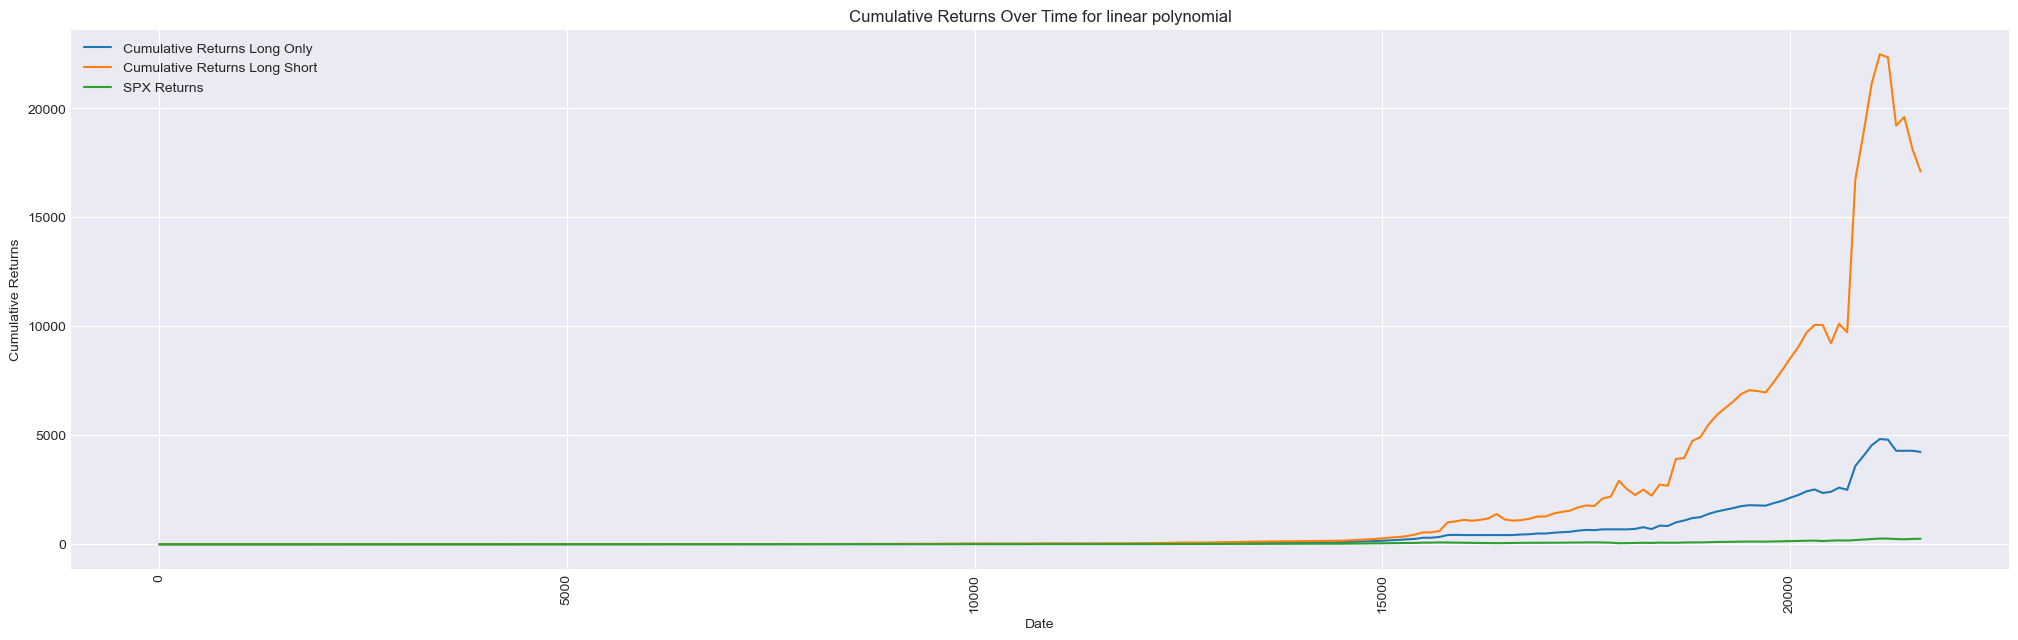

==================== Comparing Returns of Logistic Regression for linear polynomial ====================

Returns from SPX Index : $ 287.38
Returns from Long Only Strategy : $ 4866.4
Returns from Long Short Strategy : $ 20122.12


In [50]:
xl_lo, xl_ls, df_idx = plot_returns(xl_pred_ls, xl_pred_lo, 'linear') 

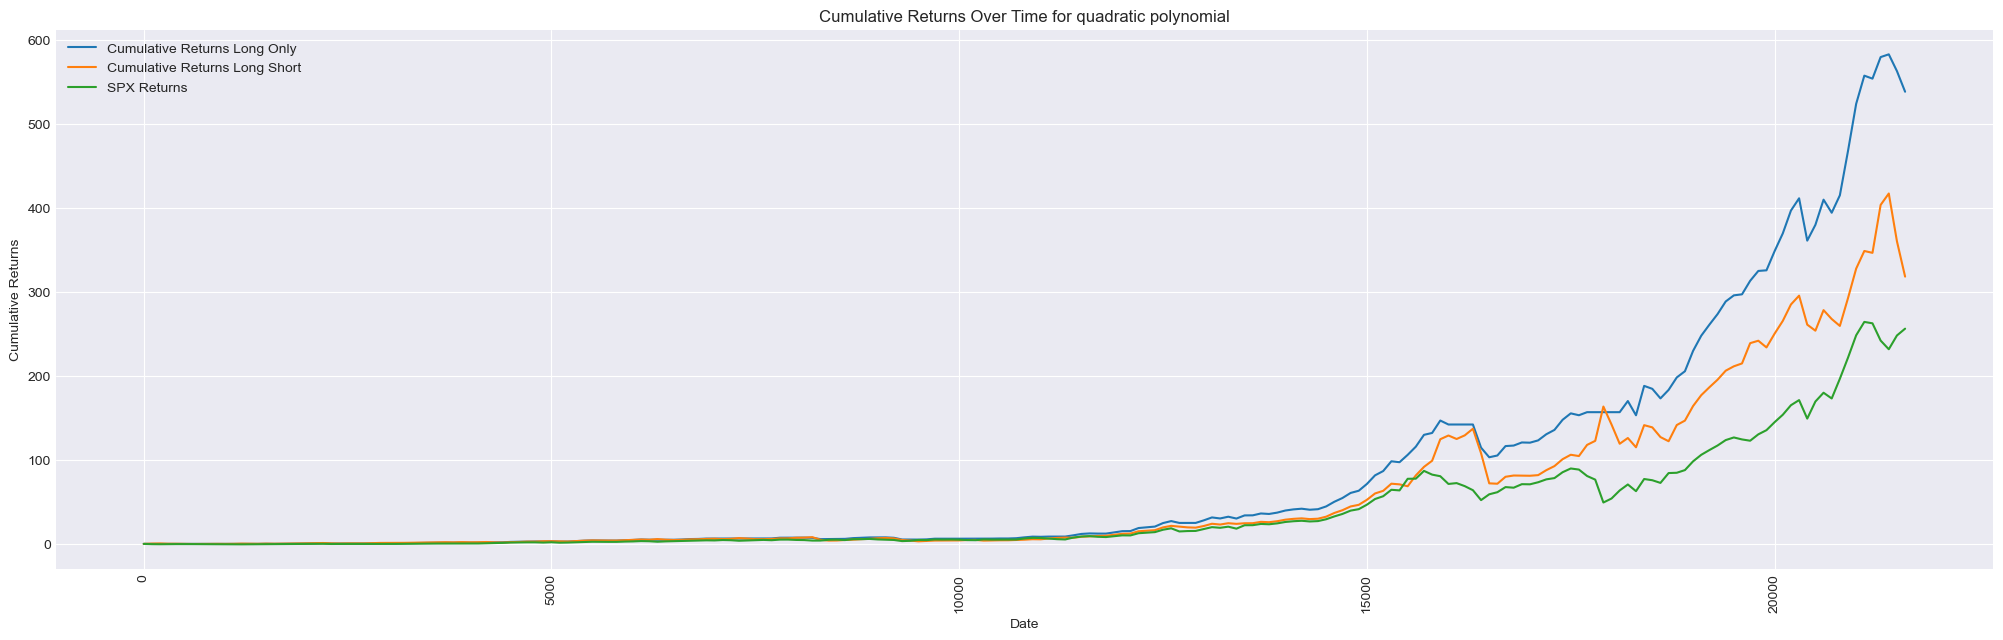

==================== Comparing Returns of Logistic Regression for quadratic polynomial ====================

Returns from SPX Index : $ 287.38
Returns from Long Only Strategy : $ 606.78
Returns from Long Short Strategy : $ 360.21


In [51]:
xq_lo, xq_ls, df_idx = plot_returns(xq_pred_ls, xq_pred_lo, 'quadratic') 

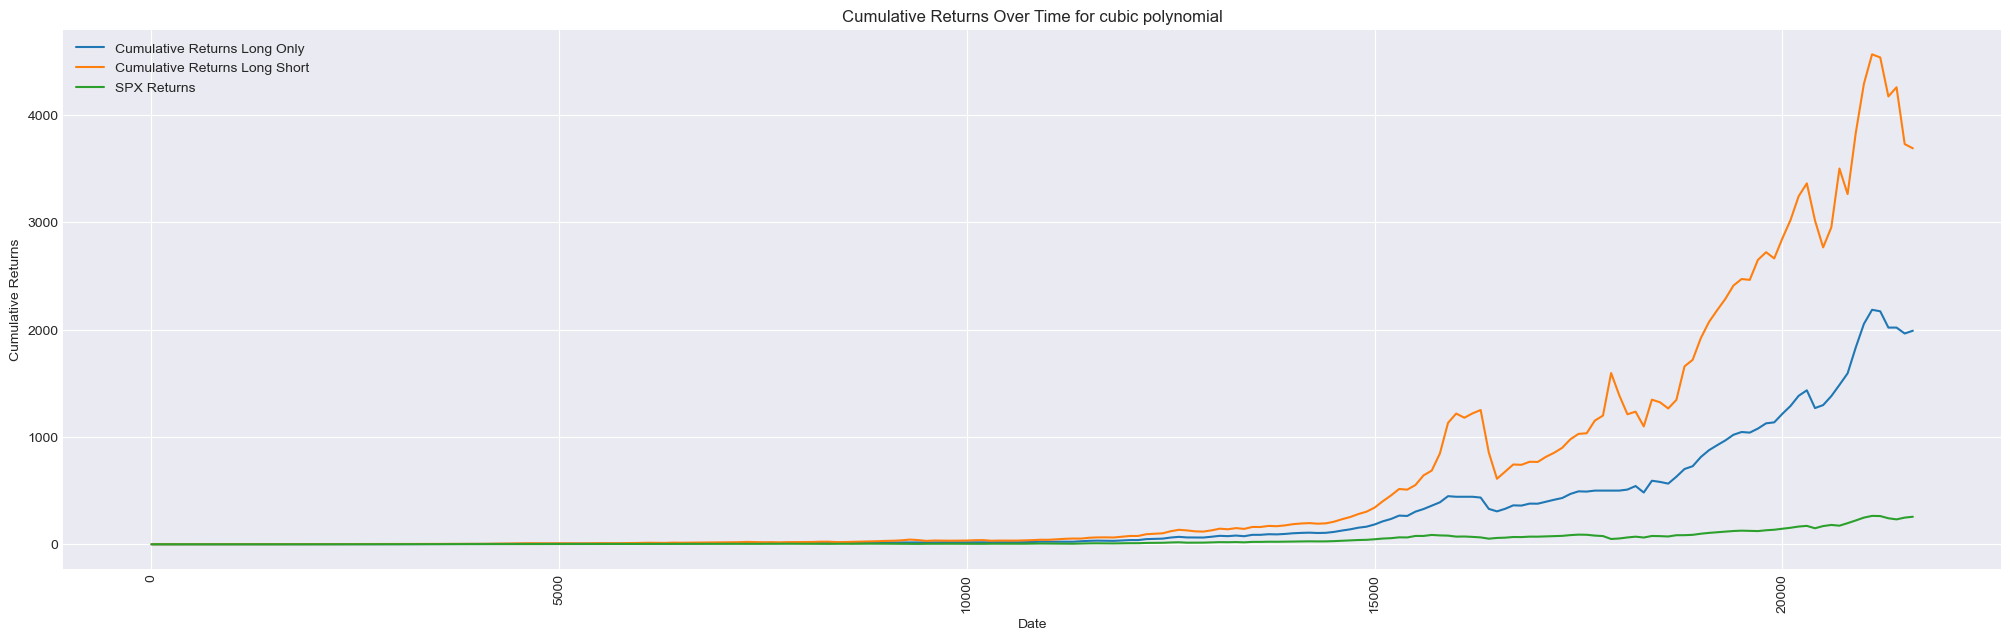

==================== Comparing Returns of Logistic Regression for cubic polynomial ====================

Returns from SPX Index : $ 287.38
Returns from Long Only Strategy : $ 2215.09
Returns from Long Short Strategy : $ 4077.16


In [52]:
xc_lo, xc_ls, df_idx = plot_returns(xc_pred_ls, xc_pred_lo, 'cubic') 

## Plot for Long Only Strategy on polynomials of different degree

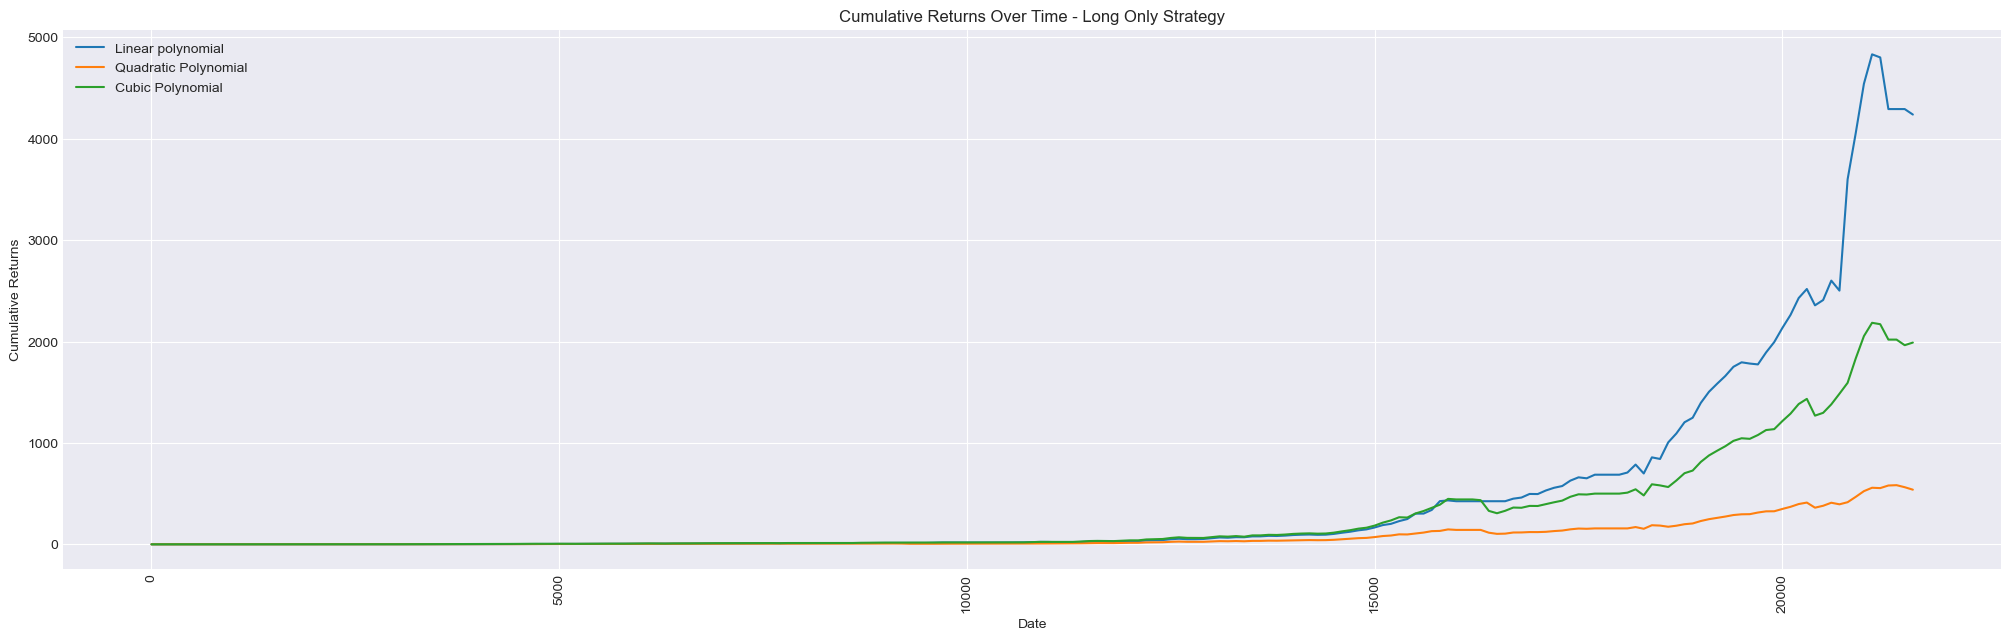

In [61]:
# df_idx.set_index('Date',inplace=True) 

plt.figure(figsize=(25, 7))
plt.plot(df_idx.index, xl_lo.values, label='Linear polynomial')
plt.plot(df_idx.index, xq_lo.values, label='Quadratic Polynomial')
plt.plot(df_idx.index, xc_lo.values, label='Cubic Polynomial')  
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time - Long Only Strategy')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show() 

## Plot for Long Short Strategy on polynomials of different degree

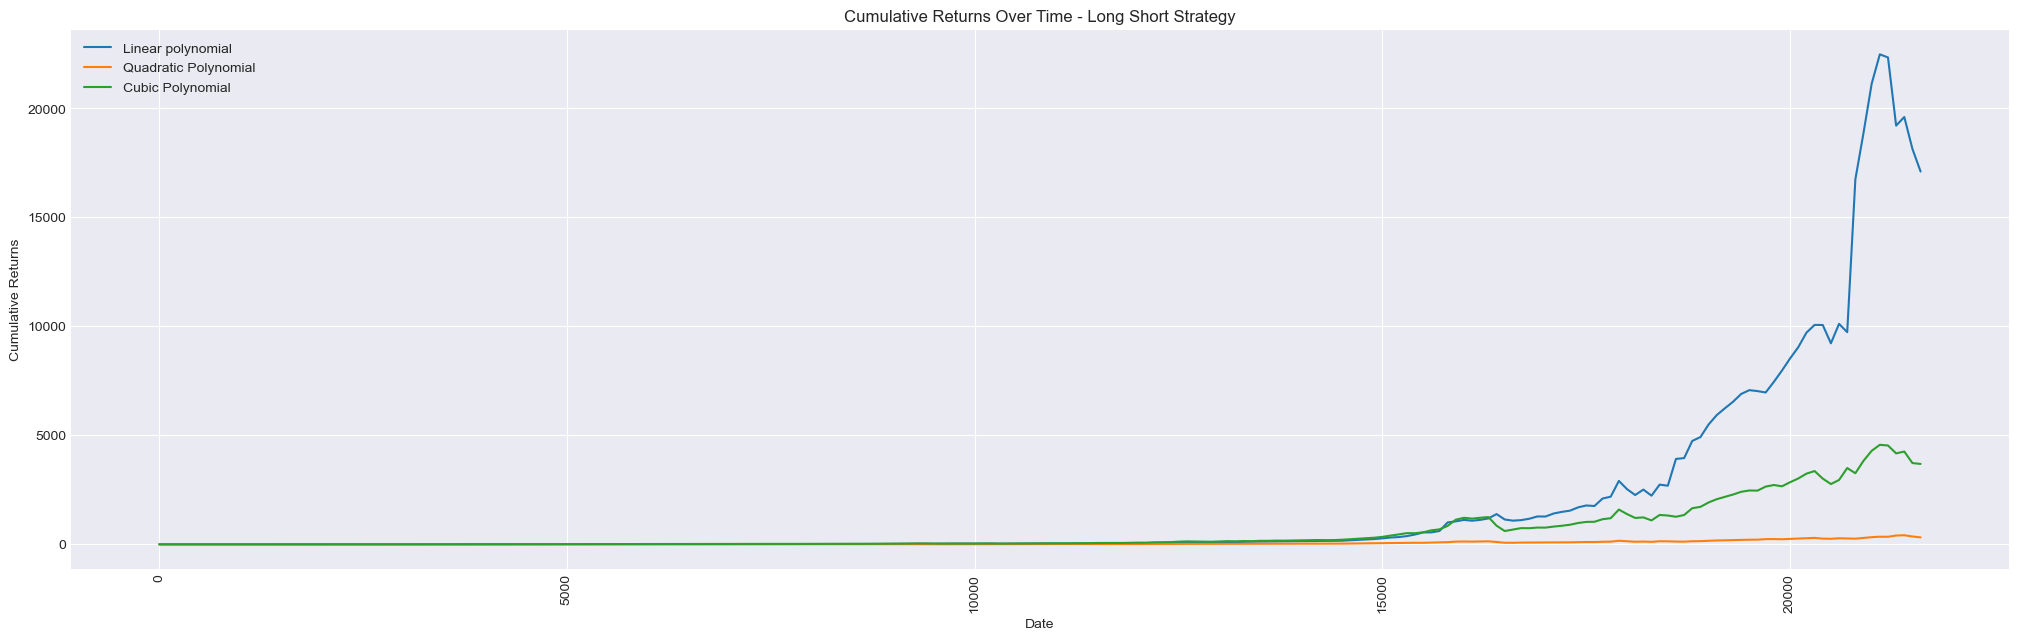

In [62]:
plt.figure(figsize=(25, 7))
plt.plot(df_idx.index, xl_ls.values, label='Linear polynomial')
plt.plot(df_idx.index, xq_ls.values, label='Quadratic Polynomial')
plt.plot(df_idx.index, xc_ls.values, label='Cubic Polynomial')  
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time - Long Short Strategy')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()  